In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch.nn import functional as F
import torchaudio
import numpy as np
import sys
sys.path.insert(0, "../")

In [3]:
from ema_cba.encoder import Encoder as EncoderCBA
from ema_cba.decoder import Decoder
from ema_cba.joiner import Joiner
from ema_cba.model import Transducer

dtype = torch.float32
encoder = EncoderCBA(
    80,
    dilations=[1 for _ in range(12)],
    kernel_size=8,
    channels=256,
    channels_expansion=1024,
    output_channels=512,
    norm='BatchNorm',
    scaled_conv=True,
    zero_init_residual=True,
    se_gate="tanh",
    gamma=0.93,
    act_bal=False,
).to(dtype).eval()
decoder = Decoder(500, 256, 0, 2).to(dtype).eval()
joiner = Joiner(512, 256, 256, 500).to(dtype).eval()
model_cba = Transducer(encoder, decoder, joiner, 512, 256, 256, 500).to(dtype).eval()

checkpoint = torch.load("small_cba_adamp_wd0.05_0.00005/epoch-124.pt", map_location='cpu')
model_cba.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [4]:
from ema.encoder import Encoder
from ema.decoder import Decoder
from ema.joiner import Joiner
from ema.model import Transducer

dtype = torch.float32
encoder = Encoder(
    80,
    dilations=[1 for _ in range(12)],
    kernel_size=8,
    channels=256,
    channels_expansion=1024,
    output_channels=256,
    norm='BatchNorm',
    scaled_conv=True,
    zero_init_residual=True,
    se_gate="tanh",
    gamma=0.93,
    act_bal=True,
).to(dtype).eval()
decoder = Decoder(500, 256, 0, 2).to(dtype).eval()
joiner = Joiner(256, 256, 256, 500).to(dtype).eval()
model = Transducer(encoder, decoder, joiner, 256, 256, 256, 500).to(dtype).eval()

checkpoint = torch.load("small_default/epoch-124.pt", map_location='cpu')
model.load_state_dict(checkpoint["model"])

<All keys matched successfully>

In [3]:
def plot_mel(mel, title=""):
    plt.figure(figsize=(7, 3))
    im = plt.imshow(mel, origin="lower", interpolation="nearest", aspect='auto')
    plt.colorbar(im)
    if title:
        plt.title(title)
    plt.show()

with open("../param.buf", "rb") as f:
    ft_weight = torch.frombuffer(f.read(512*400*4), dtype=torch.float32).view(512, 400)
    mel_fbank = torch.frombuffer(f.read(80*256*4), dtype=torch.float32).view(80, 256)

hop, window = 160, 400
x, sr = torchaudio.load("/home/shahn/Documents/sherpa-onnx/sherpa-onnx-kws-zipformer-gigaspeech-3.3M-2024-01-01/test_wavs/0.wav")
wav_len = x.size(-1) // hop * hop
x = x[0, :wav_len]
x = F.pad(x, (window - hop, 0))
ipd.display(ipd.Audio(x.numpy(), rate=16_000, normalize=False))
spec_len = torch.tensor([(x.size(0) - window + hop) // hop], dtype=torch.int64)

fp16 = True
EPS = -15.9453

def Q(x):
    if not fp16:
        return x
    x = x.to(torch.float16)
    mag = x.abs()
    return torch.where(mag < 2**-14, torch.zeros_like(x), x).float()

/tmp/ipykernel_2408983/2913907369.py:10: UserWarning: The given buffer is not writable, and PyTorch does not support non-writable tensors. This means you can write to the underlying (supposedly non-writable) buffer using the tensor. You may want to copy the buffer to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:1462.)
  ft_weight = torch.frombuffer(f.read(512*400*4), dtype=torch.float32).view(512, 400)


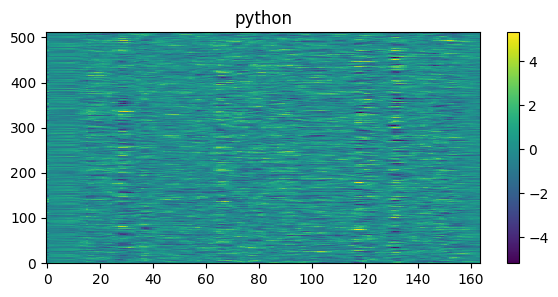

In [74]:
def calc_pytorch():
    y = x.as_strided(size=(spec_len, window), stride=(hop, 1))

    # remove DC
    row_means = torch.mean(y, dim=1).unsqueeze(1)
    y = Q(y - row_means)

    # preemphasis
    y_prev = F.pad(y.unsqueeze(0), (1, 0), mode="replicate").squeeze(0)
    y = Q(y - 0.97 * y_prev[:, :-1])

    # Window + STFT
    y = Q(F.linear(y.float(), ft_weight, None))

    # magnitude
    y = Q(y.view(spec_len, 2, 256).abs().sum(dim=1))

    # Log Mel
    y = Q(Q(Q(F.linear(y, mel_fbank)).clamp_min(0.000345266977)).log()).transpose(0, 1).unsqueeze(0)

    with torch.no_grad():
        # conv_pre
        y = (y - model.mean) * model.rstd
        y = model.conv_pre.pointwise(y)
        y = model.conv_pre.depthwise(y)
        _norm = model.conv_pre.norm
        y = (y - _norm.running_mean.view(1, -1, 1)) / _norm.running_var.view(1, -1, 1).sqrt()
        lengths = spec_len // 4
        # y, lengths = model.conv_pre(y, spec_len)
        
        # blocks
        y_in = y
        for idx_layer, block in enumerate(model.cnn[:11]):
            y, lengths = block(y, lengths)   # [batch_size, channels, time]
            # print(f"{idx_layer}: {block.scale.item()}")

        # conv_post
        y = model.proj(y)  # [batch_size, channels_out, time]
        y = model.norm(y)
        return y
        
    return y

y = calc_pytorch()[0, :, :]
plot_mel(y, "python")

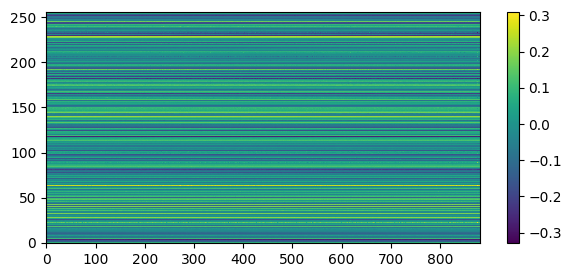

In [49]:
with torch.no_grad():
    y = torch.load("../delete_it.pt", map_location='cpu')
    y = (y - model.mean) * model.rstd
    y, lengths = model.conv_pre(y, spec_len)
plot_mel(y[0])

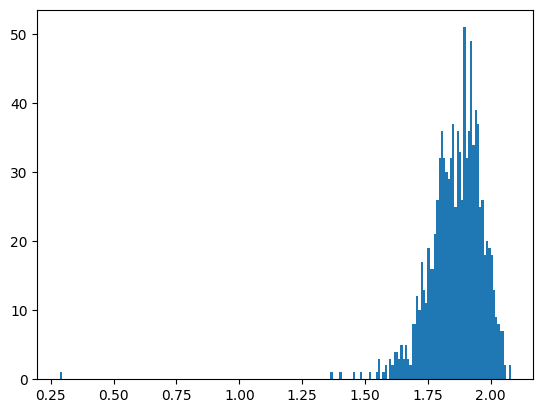

In [10]:
plt.hist(model.cnn[11].pointwise1.weight.data.square().sum(dim=(1,2)), bins=200)
# plt.hist(model.cnn[0].pointwise1.weight.data.view(-1), bins=500)
# plt.xlim(-1, 1)
# plt.hist(model.cnn[11].scale.data.abs().view(-1),bins=50)
# plt.hist(torch.tanh(model.cnn[11].se.ema.weight.data), bins=50)
plt.show()

0.48277899622917175 1.8809410333633423 0.9226842522621155 1.8962799310684204
-0.7809498906135559 2.0 0.09307275712490082 2.0
dec.scale: 1.8963651657104492


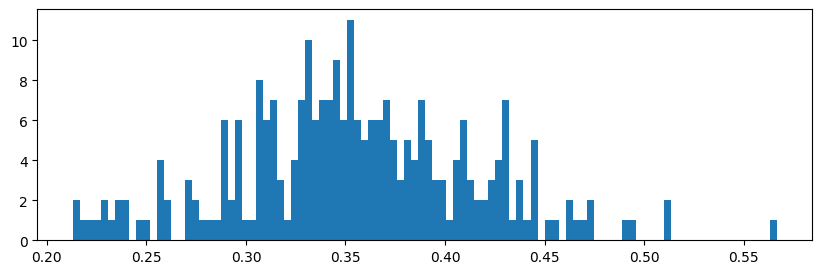

dec.scale: 2.0


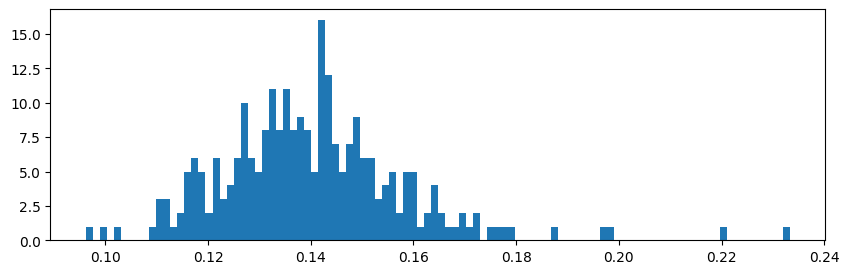

In [23]:
print(
    model_cba.simple_am_proj.weight_scale.item(),
    model_cba.simple_lm_proj.weight_scale.item(),
    model_cba.joiner.decoder_proj.weight_scale.data.item(),
    model_cba.decoder.embedding.scale.data.item(),
)
print(
    model.simple_am_proj.weight_scale.item(),
    model.simple_lm_proj.weight_scale.item(),
    model.joiner.decoder_proj.weight_scale.data.item(),
    model.decoder.embedding.scale.data.item(),
)

for _model in [model_cba, model]:
    print(f"dec.scale: {_model.decoder.conv.weight_scale.data.item()}")
    plt.figure(figsize=(10, 3))
    # plt.hist(_model.encoder.cnn[11].pointwise2.weight.data.square().sum(dim=(1,2)).sqrt(), bins=200)
    # plt.hist(_model.encoder.cnn[11].norm2.weight.data.abs(), bins=100)
    plt.hist(_model.decoder.conv.weight.data.square().sum(dim=(1,2)).sqrt(), bins=100)
    # plt.hist(_model.joiner.decoder_proj.weight.data.square().sum(dim=(1,)).sqrt(), bins=200)
    # plt.hist(_model.simple_lm_proj.weight.data.square().sum(dim=(1,)).sqrt(), bins=200)
    plt.show()

In [4]:
from encoder import EMA
import torch
from torch import nn
from partition_params import update_param_groups
from optim import ScaledAdam

class CustomModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Conv1d(2, 3, 1)
        self.ema = EMA(3)
        self.norm = nn.BatchNorm1d(3)
        self.conv_post = nn.Conv1d(3, 1, 1)
    def forward(self, x):
        x = self.conv(x)
        x = self.ema(x)
        x = self.norm(x)
        x = self.conv_post(x)
        return x

model = CustomModel()
no_wd = {
    "regex_list": ["ema\\.weight", "norm\\.weight", "nbias"],
    "clamp": False,
    "weight_decay": 0.0
}
param_groups, param_names = update_param_groups(model, [no_wd])
optim = ScaledAdam(param_groups, parameters_names=param_names)
optim.zero_grad()
x = torch.randn(10, 2, 100)
y = model(x)
y.sum().backward()
optim.step()

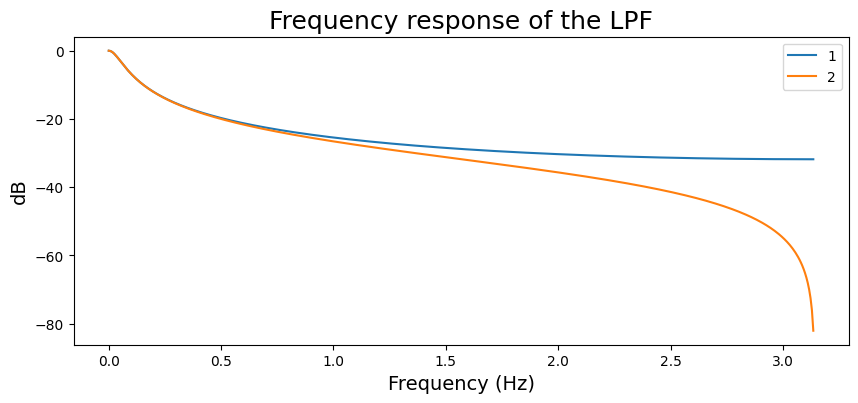

In [132]:
from scipy import signal
import numpy as np

gamma = 0.95
# sos = [[(1+gamma)/2, -(1+gamma)/2, 0, 1, -gamma, 0]]
sos1 = [[1-gamma, 0, 0, 1, -gamma, 0]]
sos2 = [[(1-gamma)/2, (1-gamma)/2, 0, 1, -gamma, 0]]
w1, H1 = signal.sosfreqz(sos1)
w2, H2 = signal.sosfreqz(sos2)
dB1 = 20 * np.log10(abs(H1))
dB2 = 20 * np.log10(abs(H2))
plt.figure(figsize=(10, 4))
plt.plot(w1, dB1, label='1')
plt.plot(w2, dB2, label='2')
plt.title("Frequency response of the LPF", fontsize=18)
plt.ylabel("dB", fontsize=14)
plt.xlabel("Frequency (Hz)", fontsize=14)
plt.legend()
plt.show()